In [1]:
import torch
import torch.distributions as D
import numpy as np

import sw

from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.linalg import expm
from sklearn.datasets import make_spd_matrix
from mpl_toolkits import mplot3d

from swgf_optimizer import *
from utils_2d import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Sliced-Wasserstein Gradient Flow on Discretized Grid

We focus on the Fokker-Planck PDE:

**Fokker-Planck Equation**:
- PDE:
\begin{equation}
    \frac{\partial\rho}{\partial t} = \mathrm{div}(\rho\nabla V)+\Delta \rho
\end{equation}
- Associated SDE:
\begin{equation*}
    \mathrm{d}x_t = \nabla V(x)\mathrm{d}t+\sqrt{2}\mathrm{d}w_t
\end{equation*}


**JKO Scheme in SW Space**:

We want to solve at each step:

\begin{equation*}
    \rho_{k+1}^\tau = \mathrm{argmin}_{\rho\in\Sigma_n}\ \frac{1}{2\tau}SW_2^2(\rho,\rho_k^\tau) + J(\rho)
\end{equation*}
with 
\begin{equation}
    \begin{aligned}
        J(\rho) &= \int V(x)\rho(x)\mathrm{d}x + \int \log(\rho(x))\rho(x)\mathrm{d}x \\
        &\approx \sum_{i=1}^n V(x_i)\rho_i + \sum_{i=1}^n \rho_i \log(\frac{\rho_i}{l})
    \end{aligned}
\end{equation}
where $l$ represents a volume of each grid point (in 1d, $l=\frac{b-a}{n}$).

($u(\rho)=\rho\log(\rho)$ and it approximated by $\bar{u}(r_i)=u(\frac{r_i}{l})\cdot l = \log(\frac{r_i}{l})r_i$, see p19 of https://arxiv.org/abs/1512.02783)

- Discrete approximation of the Lebesgue measure: $L=l\sum_{i=1}^n \delta_{x_i}$
- Discrete approximation of the Lebesgue density of $\rho$: $\left(\frac{\rho_i}{l}\right)_i$

(In 1D, $SW_2^2=W_2^2$)

### Gaussian cased with closed-form

\begin{equation*}
    \mathrm{d}X_t = -AX_t\mathrm{d}t+\sqrt{2}\mathrm{d}W_t
\end{equation*}
Here, $V(x)=\frac12 X^T A X$.
We will take $A=I$ and initialize with $\rho_0=\mathcal{N}(\mu_0,\Sigma_0)$ and $\mu_0=\begin{pmatrix}2 \\ 2 \end{pmatrix}$, $\Sigma_0 = 4 I_2$.

The analytical pdf at each time $t$ is $\mathcal{N}\Big(\exp(-At)\mu_0,(\Sigma_0-A^{-1})\exp(-2At)+A^{-1}\Big)$.

In [ ]:
A = torch.tensor(np.eye(2),dtype=torch.float).to(device)
# V = lambda x : x.T@(A@x)/2

mu0 = torch.tensor(np.array([2,2]),device=device,dtype=torch.float)
sigma0 = torch.tensor(4*np.eye(2),device=device,dtype=torch.float)

A2 = A.detach().cpu().numpy()
mu02 = mu0.detach().cpu().numpy()
sigma02 = sigma0.detach().cpu().numpy()
A2_ = np.linalg.inv(A2)

def true_mu(t):
    B = expm(-A2*t)
    return B@mu02

def true_Sigma(t):
    e = expm(-2*A2*t)
    s = (sigma02-A2_)@e+A2_
    return s

mu_stationary = np.zeros(2)
sigma_stationary = A2

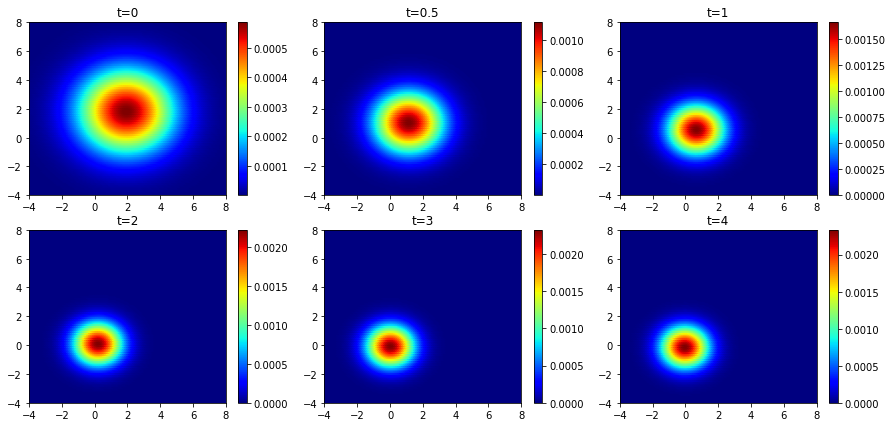

In [ ]:
x_min = -4
x_max = 8
n_samples = 100

x = np.linspace(x_min,x_max,n_samples)
y = np.linspace(x_min,x_max,n_samples)
xx, yy = np.meshgrid(x,y)

grid = np.concatenate([xx.flatten()[None,:].T,yy.flatten()[None,:].T], axis=1)

plot_true_density(grid, true_mu, true_Sigma)

In [ ]:
def V(x):
    x = x[:,:,None]   
    y = torch.matmul(A,x)
    z = torch.matmul(torch.transpose(x,1,2),y)
    return z[:,0,0]/2

def J(x, rho, delta):
    l = delta # ((x_max-x_min)/n_samples)**2    
    rho = rho.reshape(-1,1)
    rho = rho/torch.sum(rho, axis=0)
    h = torch.sum(rho*torch.log(rho/l+1e-9),axis=0) ## entropy
    
    return torch.sum(V(x)[:,None]*rho,axis=0)+h    

#### Regular SW

In [ ]:
t_init = 0
t_end = 4
h = 0.1

x_min = -4
x_max = 8
n_samples = 100

delta = ((x_max-x_min)/n_samples)**2


x = np.linspace(x_min,x_max,n_samples)
y = np.linspace(x_min,x_max,n_samples)
xx, yy = np.meshgrid(x,y)

grid = np.concatenate([xx.flatten()[None,:].T,yy.flatten()[None,:].T], axis=1)
print(grid.shape)

xs = torch.tensor(grid,dtype=torch.float).to(device)

d = 2
normal = MultivariateNormal(mu0,sigma0)
rho_0 = normal.log_prob(xs).exp()

Lrho = SWGF(xs, rho_0, h, n_step=np.int(np.ceil((t_end-t_init)/h)), n_epochs=50, 
            delta=delta, J=J, emd1D=sw.emd1D, sliced_wasserstein=sw.sliced_wasserstein,
            lr=1e-5, num_projections=1000, device=device, plot_train=False)

for k in range(len(Lrho)):
    Lrho[k] = Lrho[k].detach().cpu().numpy()
    
Lrho = np.array(Lrho)
xs = xs.detach().cpu().numpy()

(10000, 2)


  0%|          | 0/40 [00:00<?, ?it/s]

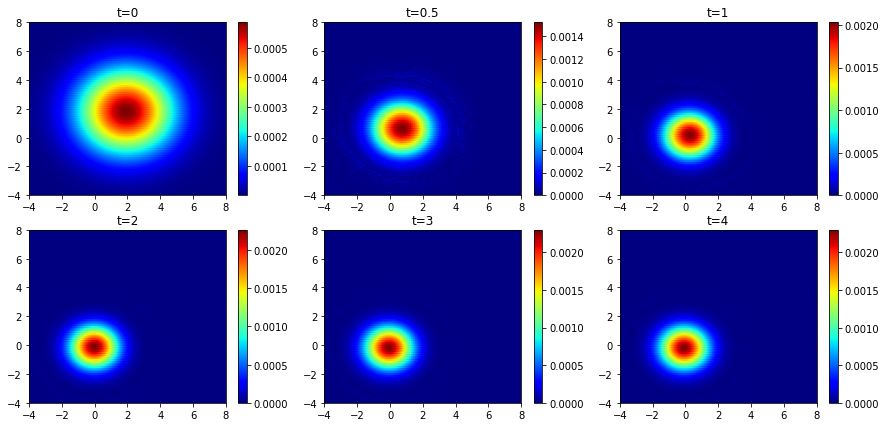

In [ ]:
plot_density(xs,Lrho)

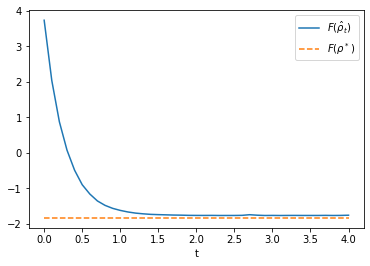

In [ ]:
distr_stationary = D.MultivariateNormal(torch.tensor(mu_stationary, dtype=torch.float, device=device),
                                       torch.tensor(sigma_stationary, dtype=torch.float, device=device))

plot_F(J,V,xs,Lrho,delta,device,distr_stationary,V,t_init=0,t_end=4)

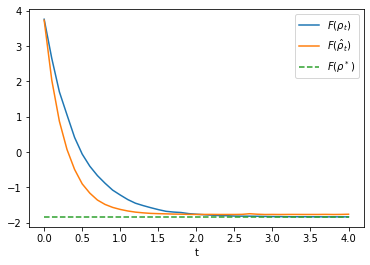

In [ ]:
plot_F_gaussians(J,xs,Lrho,delta,true_mu,true_Sigma,mu_stationary,sigma_stationary,
                 V,device,t0=0,t1=4,dilation=1)

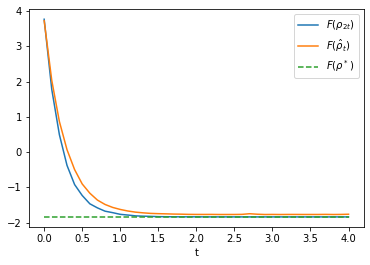

In [ ]:
plot_F_gaussians(J,xs,Lrho,delta,true_mu,true_Sigma,mu_stationary,sigma_stationary,
                 V,device,t0=0,t1=4,dilation=2)

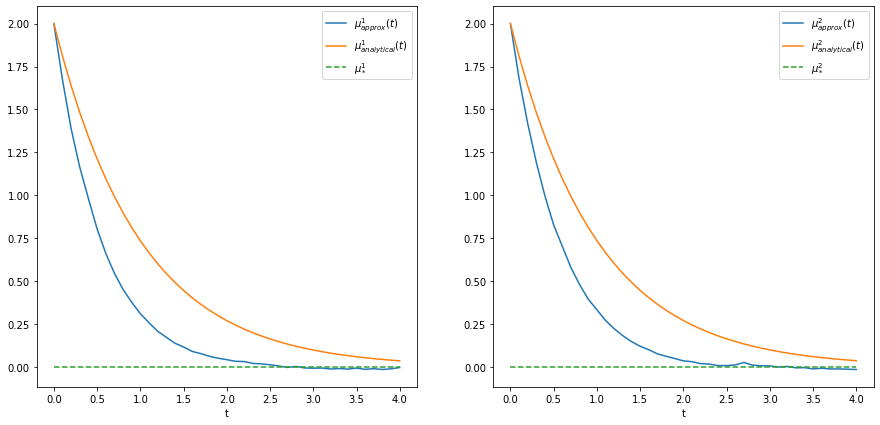

In [ ]:
plot_mean(xs, Lrho, true_mu, mu_stationary, d=2, t_init=0, t_end=4)

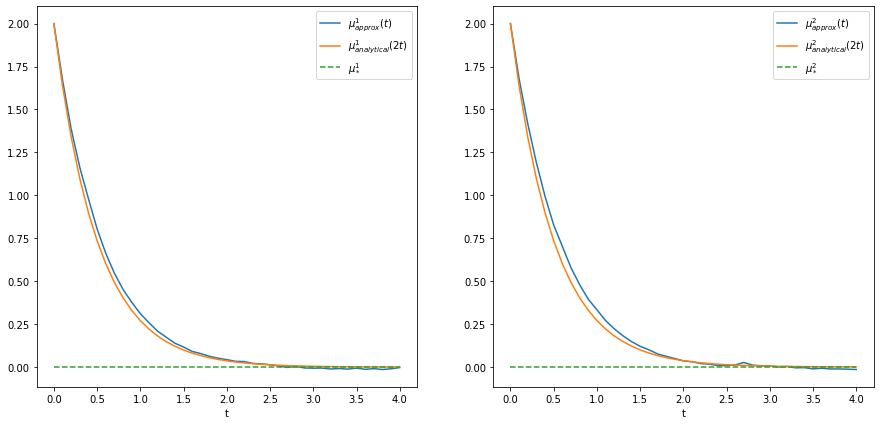

In [ ]:
plot_mean(xs, Lrho, true_mu, mu_stationary, d=2, t_init=0, t_end=4, dilation=2)

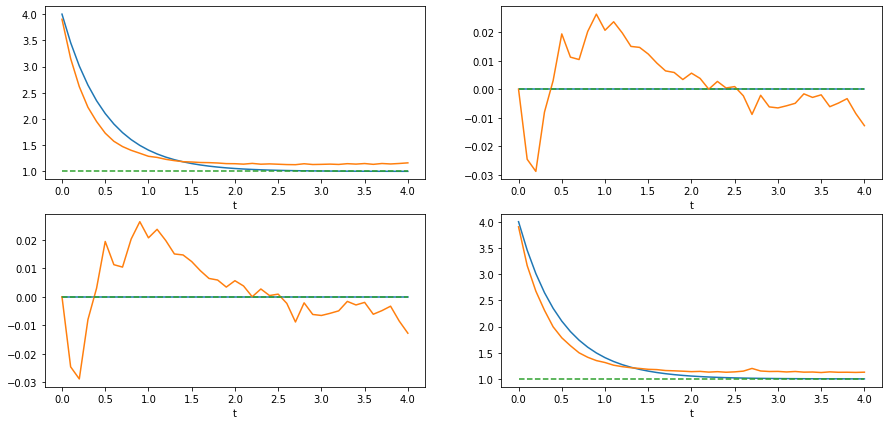

In [ ]:
plot_var(xs, Lrho, true_Sigma, sigma_stationary, d=2, t_init=0, t_end=4, dilation=1)

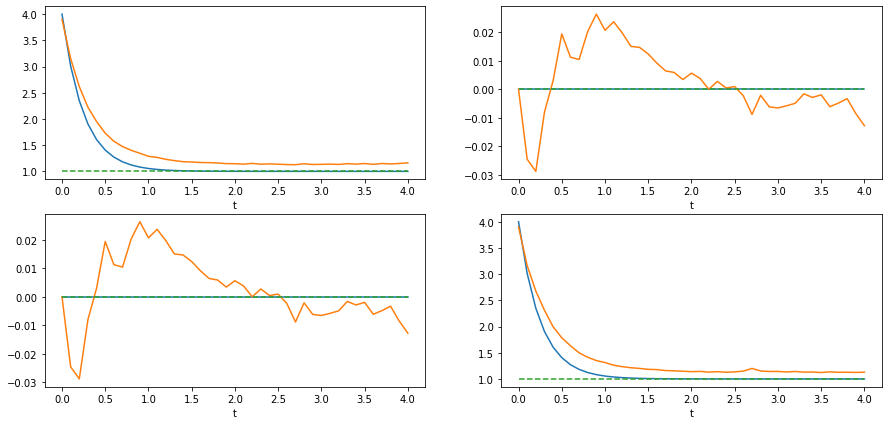

In [ ]:
plot_var(xs, Lrho, true_Sigma, sigma_stationary, d=2, t_init=0, t_end=4, dilation=2)

### Gaussian cased more complicated

In [ ]:
random_state = 42
np.random.seed(random_state)

A2 = make_spd_matrix(2, random_state=random_state)
b2 = np.random.randn(2)

A = torch.tensor(A2, dtype=torch.float).to(device)
b = torch.tensor(b2, dtype=torch.float).to(device)

mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = torch.tensor(np.eye(2),device=device,dtype=torch.float)

A2 = A.detach().cpu().numpy()
mu02 = mu0.detach().cpu().numpy()
sigma02 = sigma0.detach().cpu().numpy()
A2_ = np.linalg.inv(A2)
# b2 = b.detach().cpu().numpy()

def true_mu(t):
    B = expm(-A2*t)
    return b2+B @(mu02-b2)

def true_Sigma(t):
    e = expm(-2*A2*t)
    B = expm(-t*A2)
    A12_ = sp.linalg.sqrtm(A2_)
    cpt1 = B@sigma02@B.T
    cpt2 = A12_@(np.eye(2)-e)@A12_.T
    return cpt1+cpt2

mu_stationary = b2
sigma_stationary = A2_

def V(x):
    x = x[:,:,None]
    y = torch.matmul(A,x-b[:,None])
    z = torch.matmul(torch.transpose(x-b[:,None],1,2),y)
    return z[:,0,0]/2

def J(x, rho, delta):
    l = delta # ((x_max-x_min)/n_samples)**2    
    rho = rho.reshape(-1,1)
    rho = rho/torch.sum(rho, axis=0)
    h = torch.sum(rho*torch.log(rho/l+1e-9),axis=0) ## entropy
    
    return torch.sum(V(x)[:,None]*rho,axis=0)+h    

#### SW

In [ ]:
t_init = 0
t_end = 2
h = 0.05

x_min = -8
x_max = 8
n_samples = 100

delta = ((x_max-x_min)/n_samples)**2

x = np.linspace(x_min,x_max,n_samples)
y = np.linspace(x_min,x_max,n_samples)
xx, yy = np.meshgrid(x,y)

grid = np.concatenate([xx.flatten()[None,:].T,yy.flatten()[None,:].T], axis=1)
print(grid.shape)

xs = torch.tensor(grid,dtype=torch.float).to(device)

d = 2
normal = MultivariateNormal(mu0,sigma0)
rho_0 = normal.log_prob(xs).exp()

Lrho = SWGF(xs, rho_0, h, n_step=np.int(np.ceil((t_end-t_init)/h)), n_epochs=50, 
            delta=delta, J=J, emd1D=sw.emd1D, sliced_wasserstein=sw.sliced_wasserstein,
            lr=1e-5, num_projections=1000, device=device, plot_train=False)

for k in range(len(Lrho)):
    Lrho[k] = Lrho[k].detach().cpu().numpy()
    
Lrho = np.array(Lrho)
xs = xs.detach().cpu().numpy()

(10000, 2)


  0%|          | 0/40 [00:00<?, ?it/s]

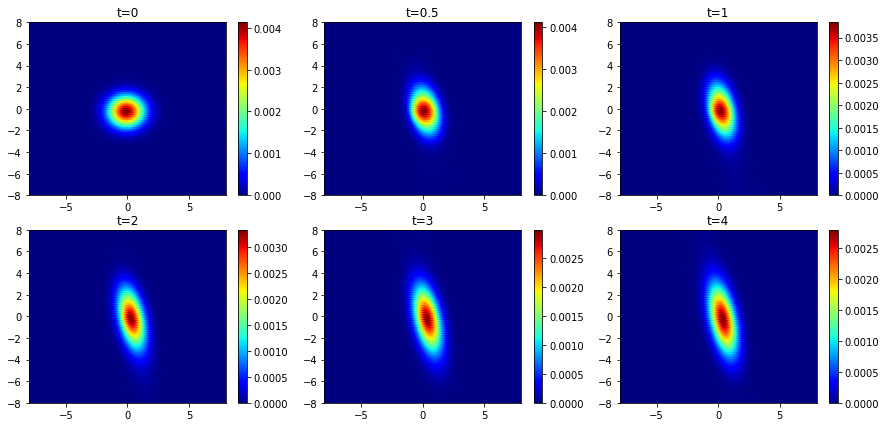

In [ ]:
plot_density(xs,Lrho,xmin=-8,ymin=-8)

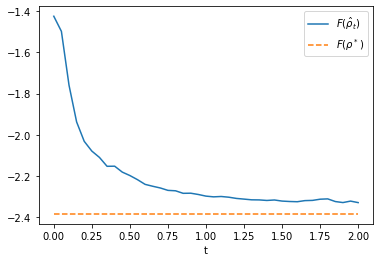

In [ ]:
distr_stationary = D.MultivariateNormal(torch.tensor(mu_stationary, dtype=torch.float, device=device),
                                       torch.tensor(sigma_stationary, dtype=torch.float, device=device))

plot_F(J,V,xs,Lrho,delta,device,distr_stationary,V,t_init=0,t_end=2)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


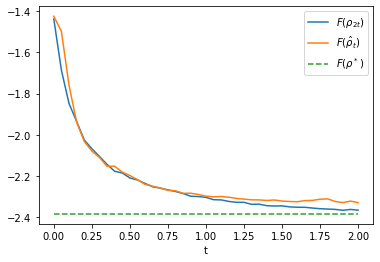

In [ ]:
plot_F_gaussians(J,xs,Lrho,delta,true_mu,true_Sigma,mu_stationary,sigma_stationary,
                 V,device,t0=0,t1=t_end,dilation=2)

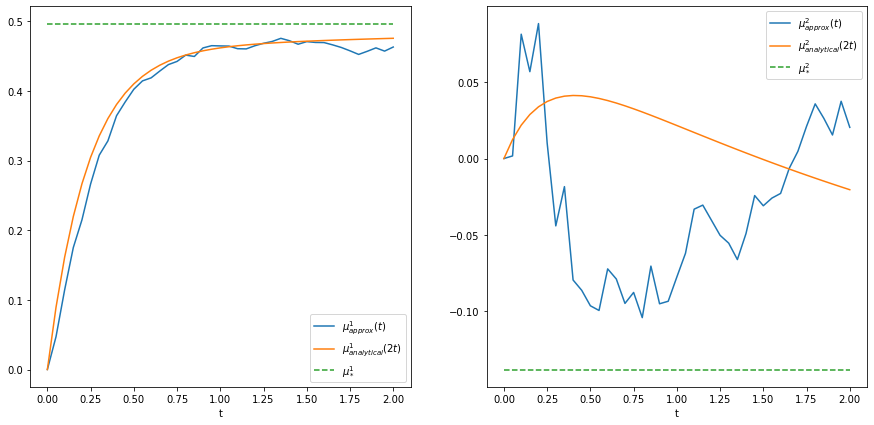

In [ ]:
plot_mean(xs, Lrho, true_mu, mu_stationary, d=2, t_init=0, t_end=2, dilation=2)

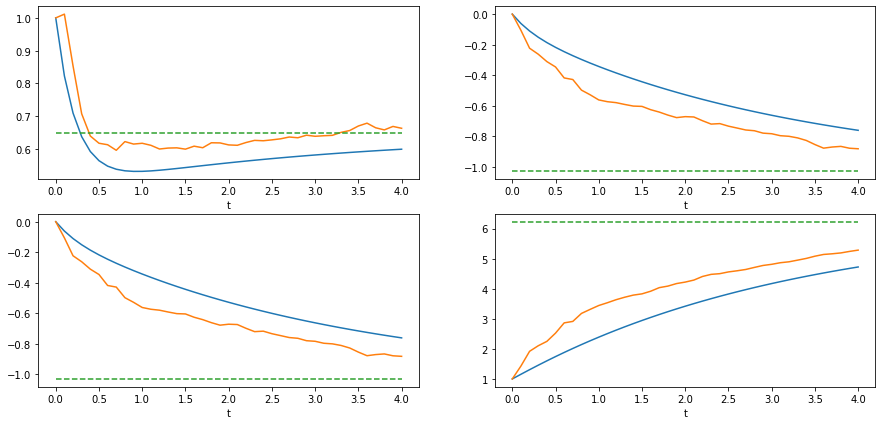

In [ ]:
plot_var(xs, Lrho, true_Sigma, sigma_stationary, d=2, t_init=0, t_end=4, dilation=1)

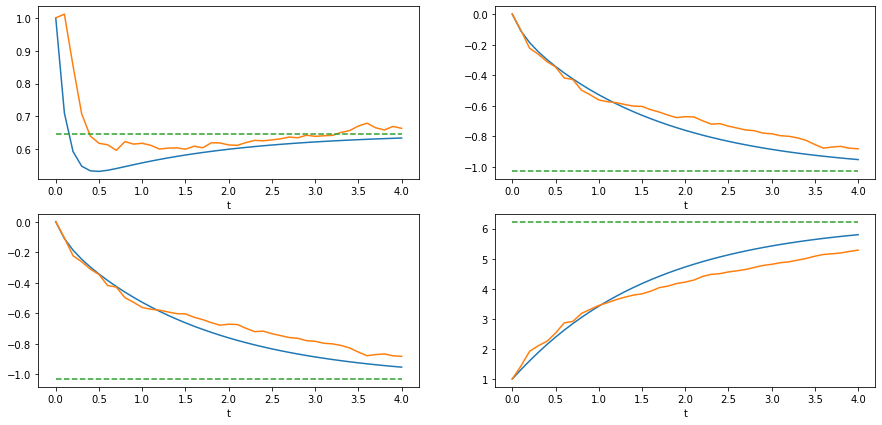

In [ ]:
plot_var(xs, Lrho, true_Sigma, sigma_stationary, d=2, t_init=0, t_end=4, dilation=2)

### Gaussian Mixture

In [ ]:
random_state = 42
torch.manual_seed(random_state)

d = 2
M = 5
l = 10

p = torch.ones(M)/M
mus = -l/2 + l * torch.rand((M,d), device=device) #, dtype=torch.float64)
sigmas = [torch.eye(d, device=device, dtype=torch.float32) for i in range(M)]

mix = D.Categorical(p.to(device))
comp = D.Independent(D.Normal(mus,torch.ones(M,d,device=device)),1)

gm = D.MixtureSameFamily(mix, comp)

def V(x):
    dists = -torch.square(torch.cdist(mus,x))/2
    return -torch.logsumexp(dists,0)

mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = 16*torch.tensor(np.eye(2),device=device,dtype=torch.float)

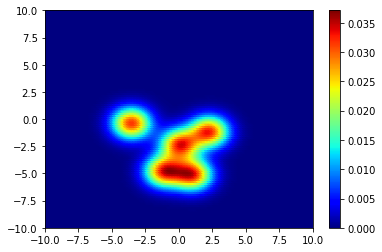

In [ ]:
xmin, xmax, ymin, ymax = -10,10,-10,10

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = gm.log_prob(torch.tensor(xyinput, dtype=torch.float32, device=device)).exp().detach().cpu()
zgrid = zz.reshape(100,100)

plt.scatter(xyinput[:,0], xyinput[:,1], c=zz, cmap="jet")
plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.show()

#### SW

In [ ]:
t_init = 0
t_end = 4
h = 0.1

x_min = -10
x_max = 10
n_samples = 100

delta = ((x_max-x_min)/n_samples)**2


x = np.linspace(x_min,x_max,n_samples)
y = np.linspace(x_min,x_max,n_samples)
xx, yy = np.meshgrid(x,y)

grid = np.concatenate([xx.flatten()[None,:].T,yy.flatten()[None,:].T], axis=1)
print(grid.shape)

xs = torch.tensor(grid,dtype=torch.float).to(device)

d = 2
normal = MultivariateNormal(mu0,sigma0)
rho_0 = normal.log_prob(xs).exp()

Lrho = SWGF(xs, rho_0, h, n_step=np.int(np.ceil((t_end-t_init)/h)), n_epochs=100, 
            delta=delta, J=J, emd1D=sw.emd1D, sliced_wasserstein=sw.sliced_wasserstein,
            lr=1e-5, num_projections=1000, device=device, plot_train=False)

for k in range(len(Lrho)):
    Lrho[k] = Lrho[k].detach().cpu().numpy()
    
Lrho = np.array(Lrho)
xs = xs.detach().cpu().numpy()

(10000, 2)


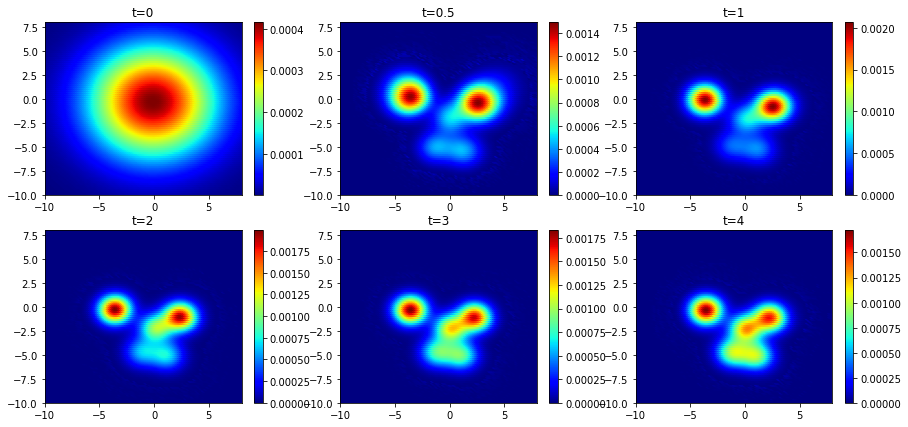

In [ ]:
plot_density(xs,Lrho,xmin=-10,ymin=-10)

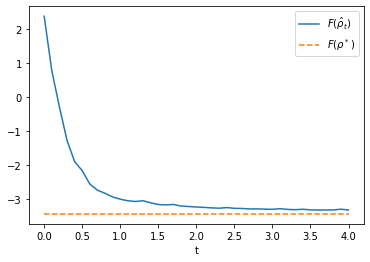

In [ ]:
plot_F(J,V,xs,Lrho,delta,device,gm,V,t_init=0,t_end=4)

### Test - Aggregation Equation

https://arxiv.org/pdf/1901.08081.pdf p 34

\begin{equation*}
    W(x)=\frac{\|x\|^4}{4} - \frac{\|x\|^2}{2}
\end{equation*}

(convention $\frac{\|x\|^0}{0}=\log\|x\|$)

In [3]:
def W(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    # return norm_x**2/2 - torch.log(norm_x)
    return norm_x**4/4 - norm_x**2/2


def J(x, rho, delta):
    l = delta # ((x_max-x_min)/n_samples)**2    
    rho = rho.reshape(-1,1)
    rho = rho/torch.sum(rho, axis=0)   

    rhos = rho*rho[:,None]
    ws = W(x-x[:,None])
    w = torch.sum(ws*rhos[:,:,0])
    return w/2  

In [4]:
t_init = 0
t_end = 10
h = 0.05

x_min = -1
x_max = 1
n_samples = 50

delta = ((x_max-x_min)/n_samples)**2

x = np.linspace(x_min,x_max,n_samples)
y = np.linspace(x_min,x_max,n_samples)
xx, yy = np.meshgrid(x,y)

grid = np.concatenate([xx.flatten()[None,:].T,yy.flatten()[None,:].T], axis=1)
print(grid.shape)

xs = torch.tensor(grid,dtype=torch.float).to(device)

d = 2
mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = torch.tensor(0.25**2 * np.eye(2),device=device,dtype=torch.float)

normal = MultivariateNormal(mu0,sigma0)
rho_0 = normal.log_prob(xs).exp()

Lrho = SWGF(xs, rho_0, h, n_step=np.int(np.ceil((t_end-t_init)/h)), n_epochs=300, 
            delta=delta, J=J, emd1D=sw.emd1D, sliced_wasserstein=sw.sliced_wasserstein,
            lr=1e-4, num_projections=1000, device=device, plot_train=False)

for k in range(len(Lrho)):
    Lrho[k] = Lrho[k].detach().cpu().numpy()
    
Lrho = np.array(Lrho)
xs = xs.detach().cpu().numpy()

(2500, 2)


  0%|          | 0/200 [00:00<?, ?it/s]

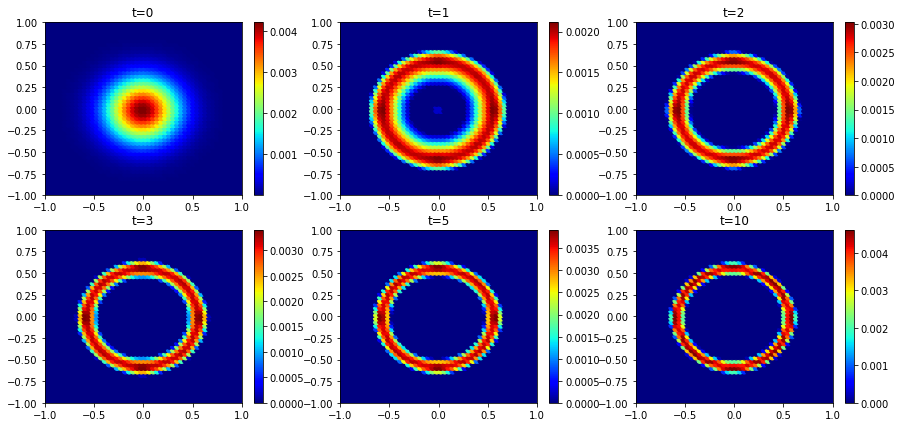

In [5]:
def plot_density(xs, Lrho, xmin=-4, xmax=8, ymin=-4, ymax=8, t1=10):
    fig, ax = plt.subplots(2,3,figsize=(15,7))
    inds = [0,1,2,3,5,10]

    for ind,t in enumerate(inds):
        i = ind//3
        j = ind%3
        
        k = int(t*(len(Lrho)-1)/t1)
        cb = ax[i,j].scatter(xs[:,0], xs[:,1], c=Lrho[k],cmap="jet")
        ax[i,j].set_ylim(ymin,ymax)
        ax[i,j].set_xlim(xmin,xmax)
        fig.colorbar(cb, ax=ax[i,j])
        ax[i,j].set_title("t="+str(t))
        
    plt.show()


plot_density(xs,Lrho,xmin=-1,ymin=-1,xmax=1,ymax=1)

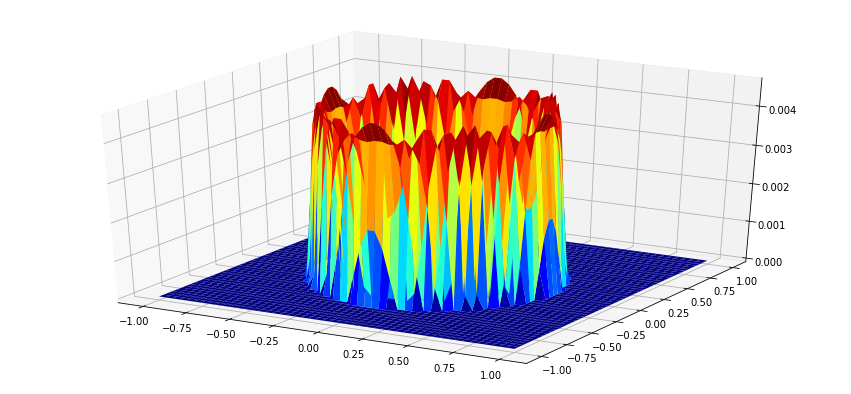

In [11]:
fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(1,1,1,projection="3d")
ax.plot_surface(xx, yy, Lrho[-1].reshape(50,50), cmap="jet") #, c=zz)
# ax.view_init(elev=0) #, azim=260)
plt.show()

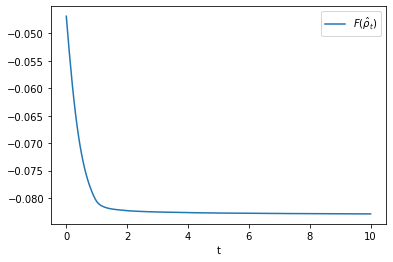

In [6]:
def plot_F(F, V, x, rho, delta, device, distr_stationary=None, d=2, n_samples=10000, 
           t_init=0, t_end=4):
    L = []

    for i in range(len(rho)):
        L.append(F(torch.tensor(x,device=device),
                   torch.tensor(rho[i],device=device),
                   delta).detach().cpu().numpy())
    
    if distr_stationary is not None:
        x_s = distr_stationary.sample((n_samples,))
        log_prob_xs = distr_stationary.log_prob(x_s)
        F_stationary = torch.mean(V(x_s), axis=0)+torch.mean(log_prob_xs, axis=0)
        F_stationary = F_stationary.detach().cpu().numpy()

    absc = np.linspace(t_init, t_end, len(L))
    plt.plot(absc, L, label=r"$F(\hat{\rho}_t)$")
    if distr_stationary is not None:
        plt.plot(absc, F_stationary*np.ones(len(absc)), '--', label=r"$F(\rho^*)$")
    plt.xlabel("t")
    plt.legend()
    plt.show()

plot_F(J, None, xs, Lrho, delta, device,t_end=10)